<div style="background-color:	#41e5d3; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">ML - Verhuuraantallen voorspellen - Heethoofd</h1>
<b style="color:white">Jasper Duncker, Julia Boschman, Nima Agha Ghafar Hamedani</b>
    </div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# metrics etc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


### Bestanden importeren

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
Xtest = test.drop(['date_hour'],axis=1)
train["date_hour"]

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
16632    2012-11-30 19:00:00
16633    2012-11-30 20:00:00
16634    2012-11-30 21:00:00
16635    2012-11-30 22:00:00
16636    2012-11-30 23:00:00
Name: date_hour, Length: 16637, dtype: object

## Opdracht 1: EDA

##### Toon datatypes en basisstatistieken

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [4]:
train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [5]:
train.isna().sum()

date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Voor het bestand train hebben we gekeken of het voldoet aan alle voorwaardes om een machine learning model te maken:

1. Het is een DataFrame
2. Het DataFrame heeft geen missende waardes
3. Het DataFrame had één kolom die geen numerieke waardes had en die is wordt omgezet naar een datetime kolom. Deze wordt ook gebruikt om nieuwe (numerieke) kolommen aan te maken.

Dus het bestand voldoet aan de voorwaardes.

In [6]:
test

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   456 non-null    object 
 1   holiday     456 non-null    int64  
 2   weathersit  456 non-null    int64  
 3   temp        456 non-null    float64
 4   atemp       456 non-null    float64
 5   hum         456 non-null    float64
 6   windspeed   456 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 25.1+ KB


In [8]:
test.describe()

,holiday,weathersit,temp,atemp,hum,windspeed
count,456.0,456.000000,456.000000,456.000000,456.000000,456.000000
mean,0.0,1.592105,0.360132,0.363691,0.714868,0.157639
std,0.0,0.607882,0.079432,0.076354,0.177732,0.106499
min,0.0,1.000000,0.160000,0.181800,0.330000,0.000000
25%,0.0,1.000000,0.300000,0.303000,0.560000,0.089600
50%,0.0,2.000000,0.360000,0.363600,0.750000,0.134300
75%,0.0,2.000000,0.400000,0.409100,0.870000,0.223900
max,0.0,3.000000,0.600000,0.621200,1.000000,0.492500


In [9]:
test.isna().sum()

date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

Net als bij het bestand train hebben wij gekeken naar de inhoud van het test bestand. Omdat wij deze gebruiken om uiteindelijk ons model mee te testen willen wij dit in de zelfde vorm hebben staan als het train bestand. Zo gaan wij ook in dit bestand de date_hour kolom omzetten naar een datetime en de kolom wordt gebruikt om verschillende kolommen met numerieke waardes aan te maken. Verder voldoet het ook aan alle voorwaardes:

1. Het is een DataFrame.
2. Het DataFrame heeft geen missende waardes.
3. Het DataFrame heeft alleen numerieke waardes.

##### Voeg tijdserie elementen toe en gebruik passende visualisaties om patronen zichtbaar te maken.

In [22]:
import pandas as pd
train['date_hour'] = pd.to_datetime(train['date_hour'])

# Voeg dag, week, maand, jaar
train['hour_of_day'] = train['date_hour'].dt.hour #Het uur van de dag (0-23).
train['day_of_week'] = train['date_hour'].dt.dayofweek #De dag van de week (maandag is 0, zondag is 6).
train['week'] = train['date_hour'].dt.isocalendar().week #De weken
train['month'] = train['date_hour'].dt.month
train['year'] = train['date_hour'].dt.year
train["day"] = train["date_hour"].dt.day

#Time series / date functionality — pandas 2.1.1 documentation. (n.d.). https://pandas.pydata.org/docs/user_guide/timeseries.html

def get_season(month):
    if month in [3, 4, 5]:  
        return 1
    elif month in [6, 7, 8]:  
        return 2
    elif month in [9, 10, 11]:
        return 3
    else: 
        return 4

train['season'] = train['month'].apply(get_season)

In [11]:
import pandas as pd
test['date_hour'] = pd.to_datetime(test['date_hour'])

# Voeg dag, week, maand, jaar
test['hour_of_day'] = test['date_hour'].dt.hour #Het uur van de dag (0-23).
test['day_of_week'] = test['date_hour'].dt.dayofweek #De dag van de week (maandag is 0, zondag is 6).
test['week'] = test['date_hour'].dt.isocalendar().week #De weken
test['month'] = test['date_hour'].dt.month
test['year'] = test['date_hour'].dt.year

#Time series / date functionality — pandas 2.1.1 documentation. (n.d.). https://pandas.pydata.org/docs/user_guide/timeseries.html

def get_season(month):
    if month in [3, 4, 5]:  
        return 1
    elif month in [6, 7, 8]:  
        return 2
    elif month in [9, 10, 11]:
        return 3
    else: 
        return 4

test['season'] = test['month'].apply(get_season)

##### Visualisatie 1

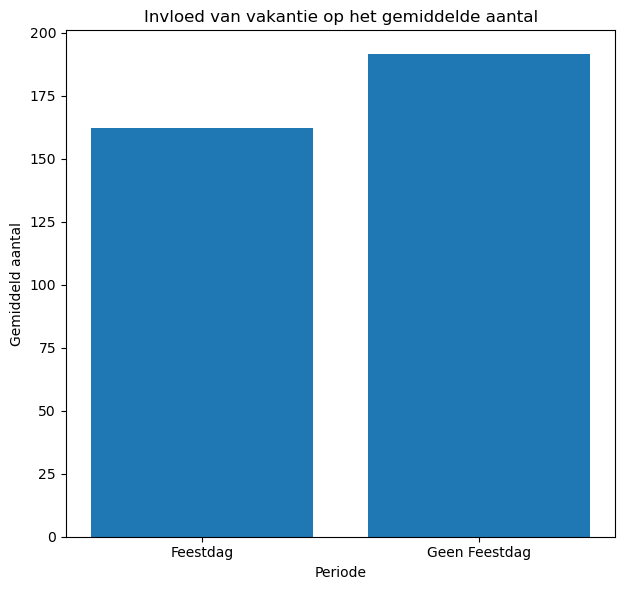

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


#Invloed van vakantie op het gemiddelde aantal
holiday_data = train[train['holiday'] == 1]
non_holiday_data = train[train['holiday'] == 0]
holiday_avg = holiday_data['cnt'].mean()
non_holiday_avg = non_holiday_data['cnt'].mean()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(['Feestdag', 'Geen Feestdag'], [holiday_avg, non_holiday_avg])
plt.xlabel('Periode')
plt.ylabel('Gemiddeld aantal')
plt.title('Invloed van vakantie op het gemiddelde aantal')


plt.tight_layout()
plt.show()

### Bevindingen feestdagen

We zien hier dat er gemiddeld minder van het product gebruikt wordt bij een feestdagen.

##### Visualisatie 2

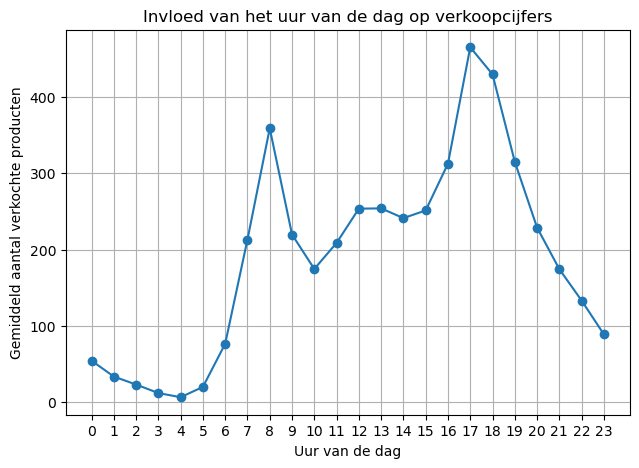

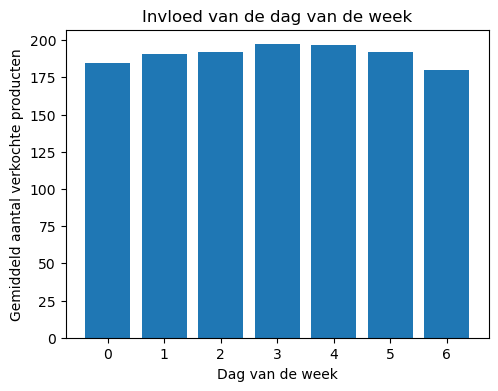

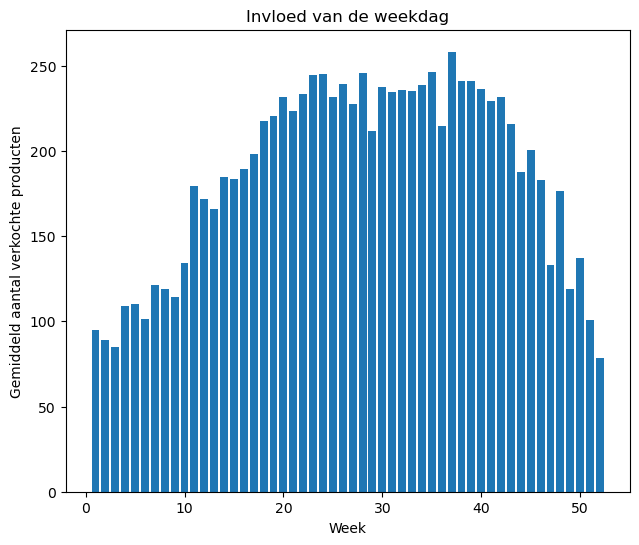

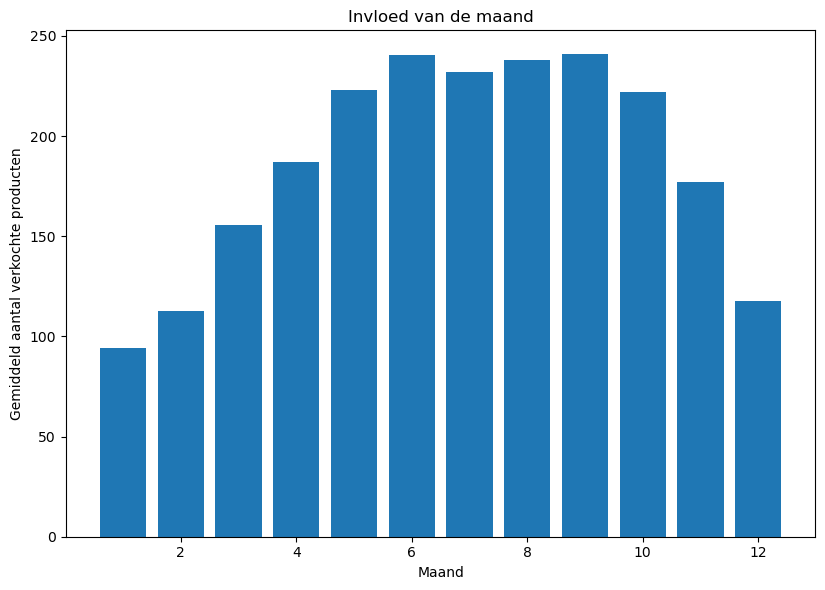

In [13]:
# Tweede grafiek: Invloed van het uur van de dag op verkoopcijfers
hourly_avg = train.groupby('hour_of_day')['cnt'].mean()
plt.figure(figsize=(16, 5))
plt.subplot(122)
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel('Uur van de dag')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van het uur van de dag op verkoopcijfers')
plt.xticks(range(24))
plt.grid(True)

# Invloed van de dag van de week op de verkoop

day_of_week_avg = train.groupby('day_of_week')['cnt'].mean()
plt.figure(figsize=(12, 4))
plt.subplot(122)
plt.bar(day_of_week_avg.index, day_of_week_avg.values)
plt.xlabel('Dag van de week')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de dag van de week')

# Invloed van de week op de verkoop
plt.figure(figsize=(16, 6))

weekday_avg = train.groupby('week')['cnt'].mean()
plt.subplot(122)
plt.bar(weekday_avg.index, weekday_avg.values)
plt.xlabel('Week')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de weekdag')

# Invloed van de maand op de verkoop
plt.figure(figsize=(16, 6))

month_avg = train.groupby('month')['cnt'].mean()
plt.subplot(122)
plt.bar(month_avg.index, month_avg.values)
plt.xlabel('Maand')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de maand')

plt.tight_layout()
plt.show()

### Conclusie uur, dag, week, maand

#### Conclusie uur

Wij zien in deze plot dat er 2 pieken vallen. Dat is om 8 uur en om 17 uur. Deze uren vallen ook in de spitsuren. Door deze bevinding kan het product een relatie hebben met vervoer. (DPG Media Privacy Gate, n.d.)

DPG Media Privacy Gate. (n.d.). https://myprivacy.dpgmedia.nl/consent?siteKey=ujm6mv0jrqiz5syr&callbackUrl=https%3A%2F%2Fwww.autoweek.nl%2Fprivacygate-confirm%3FredirectUri%3D%252Fverkeer%252Fzo-vermijd-je-files-en-druk-verkeer-tijdens-de-spits%252F%253Freferrer%253Dhttps%25253A%25252F%25252Fwww.google.com%25252F

#### Conclusie dag

Wij zien dat er op zaterdag (5) en zondag (6) een kleine daling is tussen het gemiddeld gebruik van het product. Hiebij kan je concluderen dat het product te maken heeft met de werkdagen/schooldagen.

#### Conclusie week

We zien dat het bij het einde van de officiële zomervakantie er veel gebruikt van het product gebruikt wordt

#### Conclusie maand
We zien hierbij in de 'warmere maanden'Dat het product vaker gebruikt wordt. Hierdoor kunnen we zeggen dat het een product is dat vaak buiten gebruikt wordt.

##### Onderzoek de relatie tussen de onafhankelijke en de afhankelijke variabelen

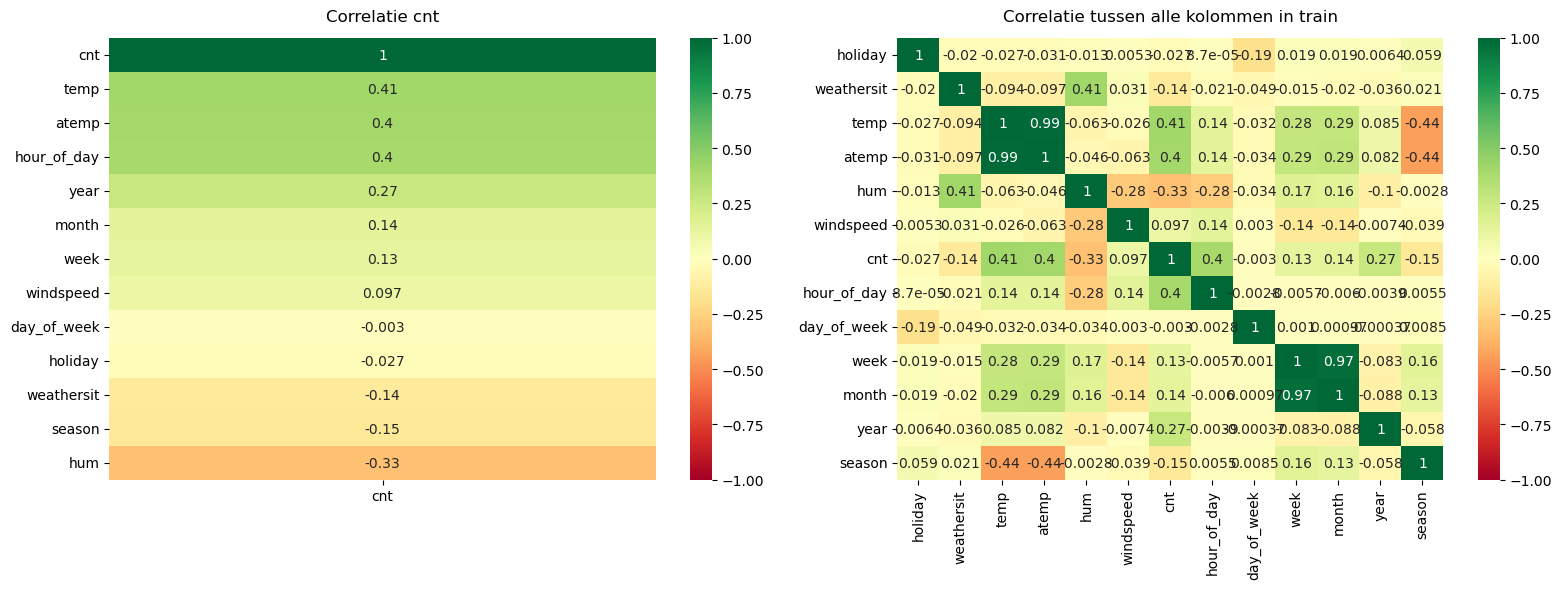

In [14]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(train.corr(method='pearson')[['cnt']].sort_values(by='cnt', ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie cnt', fontdict={'fontsize': 12}, pad=12)


plt.subplot(122) 
heatmap2 = sns.heatmap(train.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap2.set_title('Correlatie tussen alle kolommen in train', fontdict={'fontsize': 12}, pad=12)

plt.tight_layout()  
plt.show()

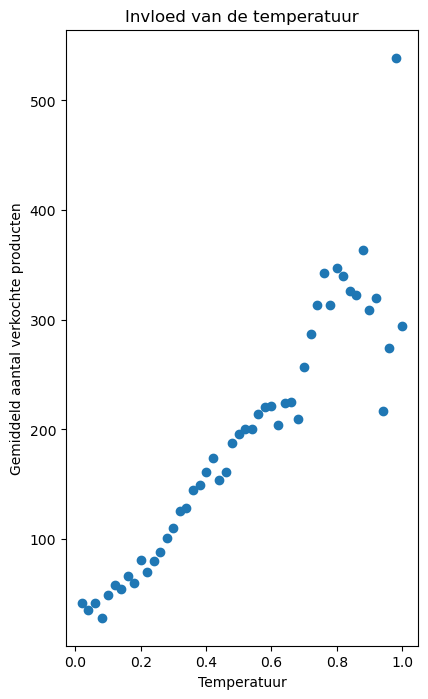

In [15]:
plt.figure(figsize=(10, 8))

temp_avg = train.groupby('temp')['cnt'].mean()
plt.subplot(122)
plt.scatter(temp_avg.index, temp_avg.values)
plt.xlabel('Temperatuur')
plt.ylabel('Gemiddeld aantal verkochte producten')
plt.title('Invloed van de temperatuur')
plt.show()

### Conclusie temperatuur
Uit deze visualisatie zien wij het volgende: Hoe warmer het weer, hoe vaker het product gebruikt. 

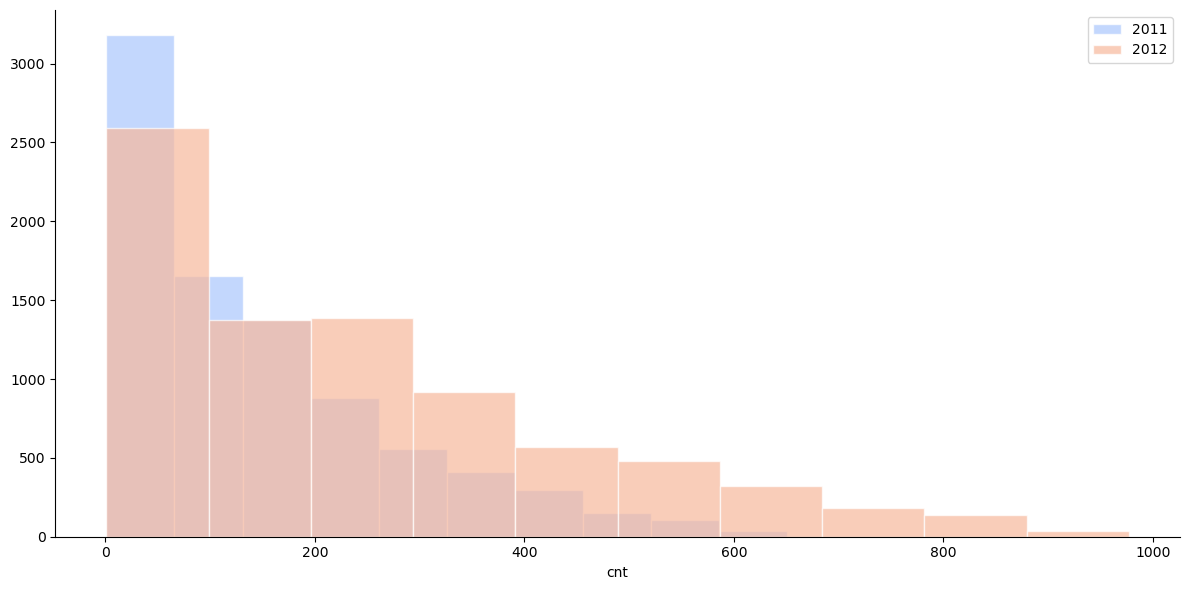

In [16]:
import seaborn as sns

g=sns.FacetGrid(train, hue='year', palette='coolwarm',height=6,aspect=2)
g=g.map(plt.hist,'cnt',alpha=0.7, edgecolor='w')
plt.legend()
plt.show()

C:\Users\bosch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


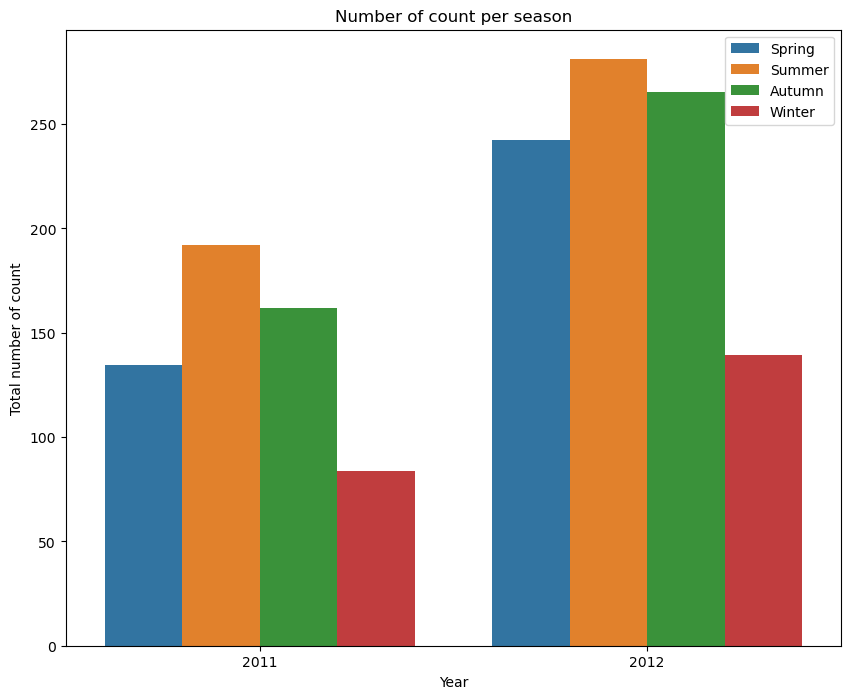

In [17]:
plt.figure(figsize=(10, 8))

sns.barplot('year', "cnt",hue='season', data=train, ci=None)
plt.legend(["Spring", "Summer", "Autumn", "Winter"])
plt.xlabel('Year')
plt.ylabel('Total number of count')
plt.title('Number of count per season')
plt.show()



### Conclusie per seizoen
Wij zien dat er in de lente, zomer en herfst meer mensen hebben besloten op het product te gebruiken dan in de winter. Hieruit kan je de hypothese stellen dat het een product is die je buiten gebruikt

C:\Users\bosch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


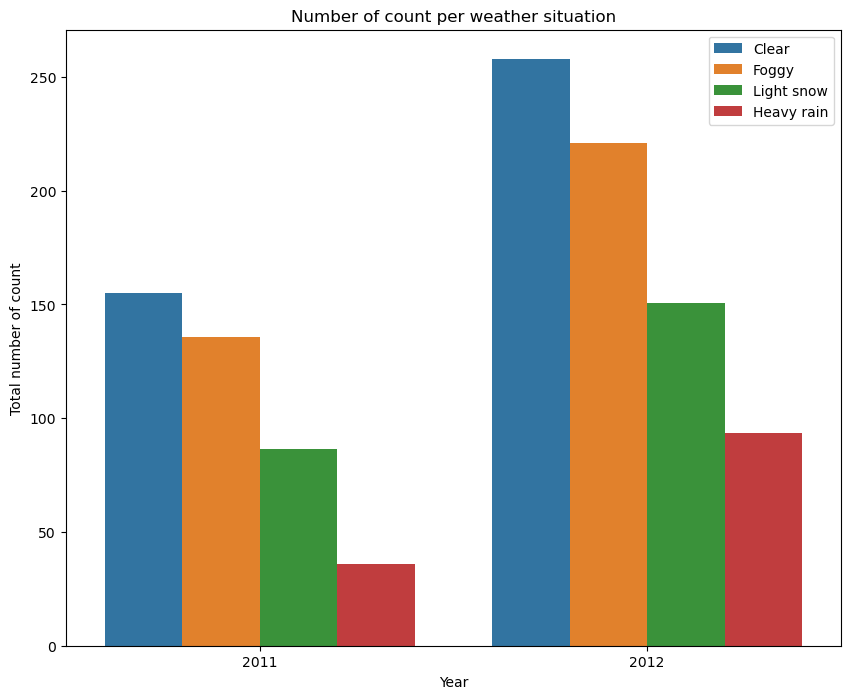

In [18]:
plt.figure(figsize=(10, 8))

sns.barplot('year', "cnt",hue='weathersit', data=train, ci=None)
plt.legend(['Clear', 'Foggy', 'Light snow', 'Heavy rain'])
plt.xlabel('Year')
plt.ylabel('Total number of count')
plt.title('Number of count per weather situation')
plt.show()

### Conclusie per seizoen
Wij zien dat hoe aantrekkelijker het weer is om naar buiten te gaan, hoe meer er van het product gebruikt wordt. Hieruit kan je de hypothese stellen dat het een product is die je buiten gebruikt

In [23]:
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour_of_day,day_of_week,week,month,year,season,day
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,52,1,2011,4,1
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,52,1,2011,4,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,52,1,2011,4,1
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,52,1,2011,4,1
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,52,1,2011,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,48,11,2012,3,30
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,48,11,2012,3,30
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,48,11,2012,3,30
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,48,11,2012,3,30


In [21]:
test

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour_of_day,day_of_week,week,month,year,season
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,48,12,2012,4
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,48,12,2012,4
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,48,12,2012,4
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,48,12,2012,4
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,48,12,2012,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,2,51,12,2012,4
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,2,51,12,2012,4
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,2,51,12,2012,4
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896,22,2,51,12,2012,4


### Metric Functie

In [19]:
def train_test_model(model):
    """
    Traint het opgegeven model met behulp van de meegeleverde trainingsgegevens en evalueert het met de testgegevens.

    Parameters:
    ----------
    model : model vergelijkbaar met sklearn
        Het model dat getraind en geëvalueerd moet worden.
    
    Returns:
    -------
    RMSE :
        Deze functie drukt de RMSE score van het model op de testgegevens af.
    
        
    """

    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = MSE**0.5
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    return print('R2:',R2,
                 '\nMAE:', MAE,
                 '\nMSE:',MSE,
                 '\nRMSE:',RMSE)

### TimeSeries

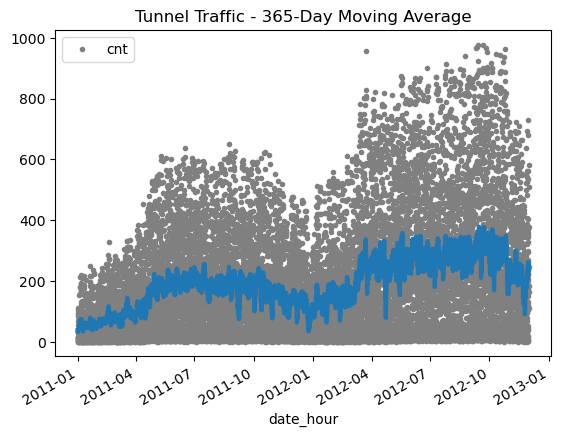

In [48]:
roll_train = train[["date_hour", "cnt"]].set_index("date_hour")

moving_average = roll_train.rolling(
    window=52,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=26,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = roll_train.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

<AxesSubplot:xlabel='date_hour'>

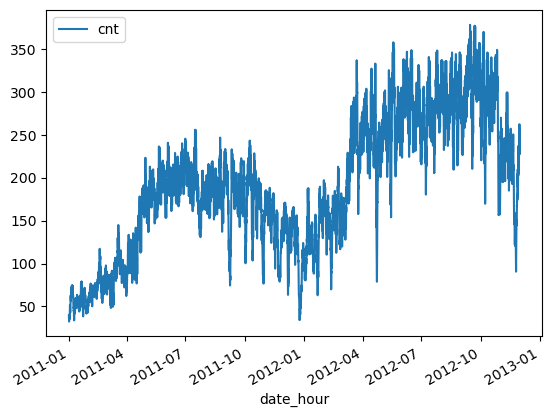

In [87]:
moving_average.plot()

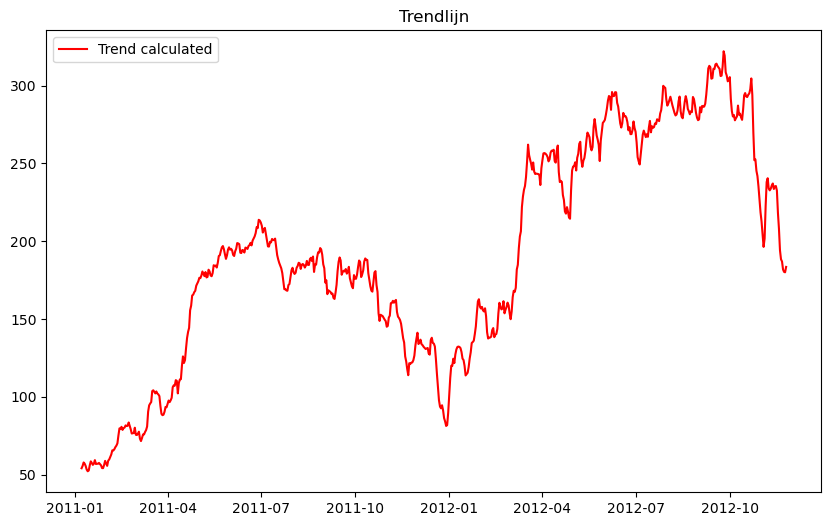

In [98]:
train['datum'] = train['date_hour'].dt.date

nieuw_dataframe = train[['datum', 'cnt']]
nieuw_dataframe.set_index('datum', inplace=True)
nieuw_dataframe.index = pd.to_datetime(nieuw_dataframe.index)

dagelijks_resampled = nieuw_dataframe.resample('D').mean()
dagelijks_resampled

#pandas.DataFrame.resample — pandas 2.1.2 documentation. (n.d.). #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

def calculate_trend(df, window_size):
    """
    Calculates the trend component using a rolling window and moving averages

    Parameters:
        df (pandas.DataFrame): DataFrame with a DateTime index and a single column.
        window_size: The length of the rolling window in units of time
    """
    trend = df.rolling(window_size, center=True).mean()
    return trend

plt.figure(figsize=(10,6))

trend_calculated = calculate_trend(dagelijks_resampled, window_size=12)

plt.plot(trend_calculated, label="Trend calculated", color="red")

plt.title("Trendlijn")
plt.legend()


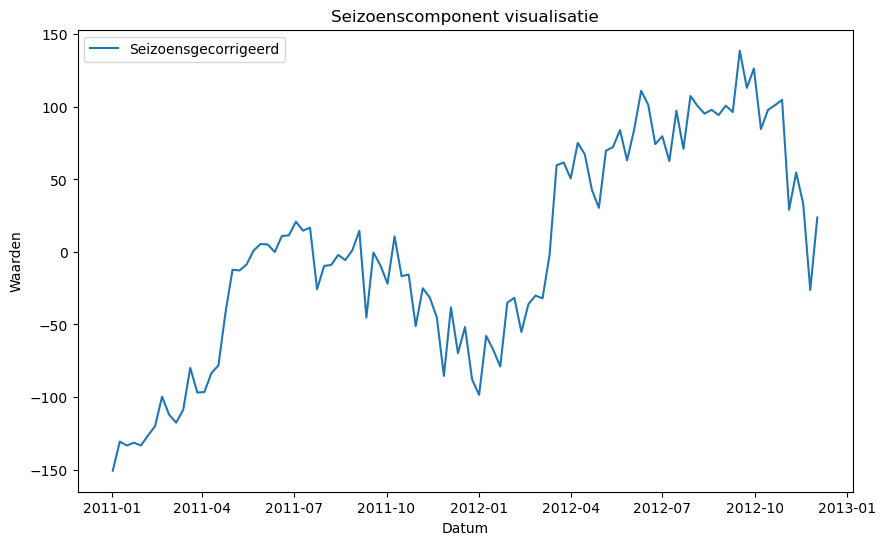

In [108]:
seasonal_pattern = weekly_resampled.groupby(weekly_resampled.index.dayofweek)['cnt'].mean()

weekly_resampled['seasonal_adjusted'] = weekly_resampled['cnt'] - weekly_resampled.index.dayofweek.map(seasonal_pattern)

plt.figure(figsize=(10, 6))


plt.plot(weekly_resampled.index, weekly_resampled['seasonal_adjusted'], label='Seizoensgecorrigeerd')
plt.xlabel('Datum')
plt.ylabel('Waarden')
plt.title('Seizoenscomponent visualisatie')
plt.legend()
plt.show()

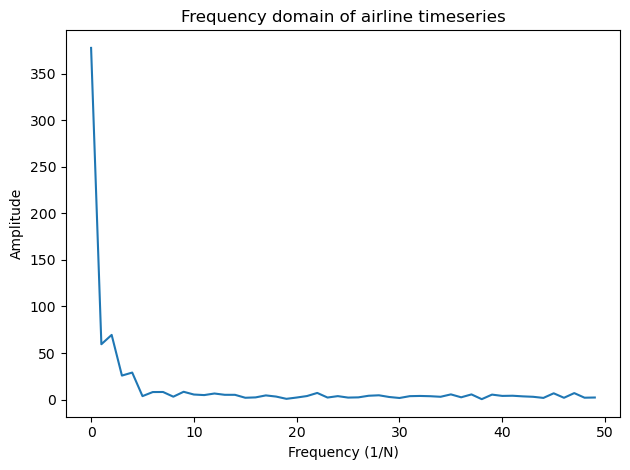

In [111]:
N = len(weekly_resampled)

# Compute the Fourier transform of the timeseries
train_ft = np.fft.fft(weekly_resampled['cnt'])

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(train_ft[:N//2])

# Plot the constituent frequencies
plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of airline timeseries")

plt.tight_layout()
plt.show()

Peaks found at [2]


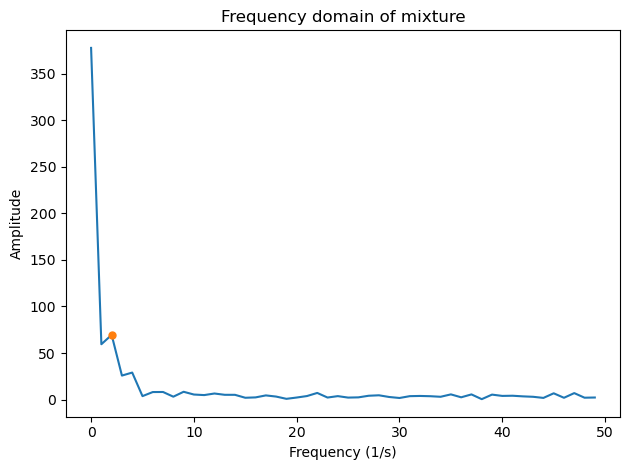

In [112]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(magnitude, height=45) # Je kunt de "height" parameter bewerken om meer of minder pieken te vinden.

print(f"Peaks found at {peaks}")

plt.plot(magnitude)
plt.xlabel('Frequency (1/s)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of mixture")

plt.plot(peaks, magnitude[peaks], ".", markersize=10)

plt.tight_layout()
plt.show()

De dominante frequenties zijn 2, 692, 694 en 1387. Wij slaan 2 over, omdat deze heel dicht bij de 0 ligt.

In [113]:
2 * (1/101)

0.019801980198019802

In [104]:
import statsmodels.api as sm

def decompose_ts(series, period=None):
    decompose = sm.tsa.seasonal_decompose(series, period=period)
    trend = decompose.trend
    seasonal = decompose.seasonal
    resid = decompose.resid
    return trend, seasonal, resid

trend, seasonal, resid = decompose_ts(roll_train, period= 12)
print(trend, seasonal, resid)

date_hour
2011-01-01 00:00:00   NaN
2011-01-01 01:00:00   NaN
2011-01-01 02:00:00   NaN
2011-01-01 03:00:00   NaN
2011-01-01 04:00:00   NaN
                       ..
2012-11-30 19:00:00   NaN
2012-11-30 20:00:00   NaN
2012-11-30 21:00:00   NaN
2012-11-30 22:00:00   NaN
2012-11-30 23:00:00   NaN
Name: trend, Length: 16637, dtype: float64 date_hour
2011-01-01 00:00:00     8.288947
2011-01-01 01:00:00    16.728538
2011-01-01 02:00:00    33.107359
2011-01-01 03:00:00    44.586571
2011-01-01 04:00:00     0.953328
                         ...    
2012-11-30 19:00:00     8.288947
2012-11-30 20:00:00    16.728538
2012-11-30 21:00:00    33.107359
2012-11-30 22:00:00    44.586571
2012-11-30 23:00:00     0.953328
Name: seasonal, Length: 16637, dtype: float64 date_hour
2011-01-01 00:00:00   NaN
2011-01-01 01:00:00   NaN
2011-01-01 02:00:00   NaN
2011-01-01 03:00:00   NaN
2011-01-01 04:00:00   NaN
                       ..
2012-11-30 19:00:00   NaN
2012-11-30 20:00:00   NaN
2012-11-30 21:00:00   Na

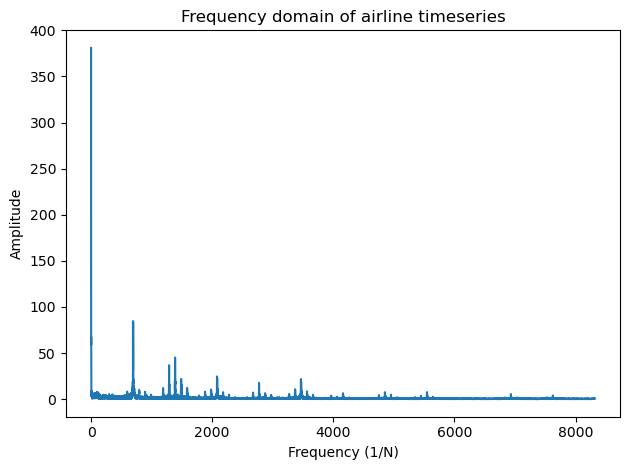

In [106]:
N = len(roll_train)

# Compute the Fourier transform of the timeseries
train_ft = np.fft.fft(roll_train['cnt'])

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(train_ft[:N//2])

# Plot the constituent frequencies
plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of airline timeseries")

plt.tight_layout()
plt.show()

Peaks found at [   2  692  694 1387]


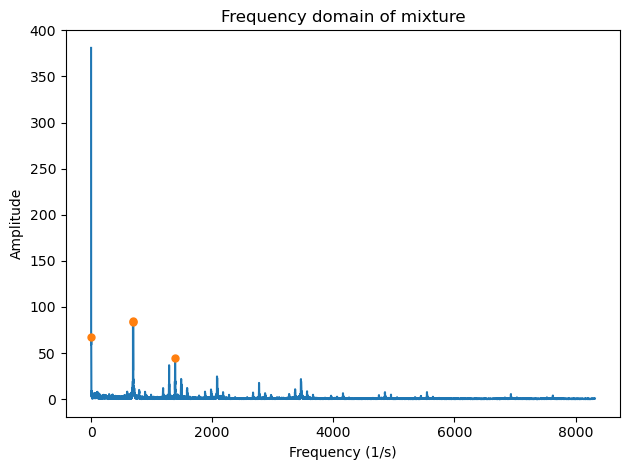

In [107]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(magnitude, height=45) # Je kunt de "height" parameter bewerken om meer of minder pieken te vinden.

print(f"Peaks found at {peaks}")

plt.plot(magnitude)
plt.xlabel('Frequency (1/s)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of mixture")

plt.plot(peaks, magnitude[peaks], ".", markersize=10)

plt.tight_layout()
plt.show()

In [97]:
692 * (1/N)

0.04159403738654806

In [74]:
train["date"] = pd.to_datetime(train['year'].astype(str) + '-' + train['month'].astype(str) + '-' + train["day"].astype(str))
train.set_index("date", inplace=True)
train["trend"] = trend
train["seasonal"] = seasonal
train["resid"] = resid
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour_of_day,day_of_week,week,month,year,season,day,trend,seasonal,resid,datum
date,,,,,,,,,,,,,,,,,,,
2011-01-01,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,52,1,2011,4,1,NaN,8.288947,NaN,2011-01-01
2011-01-01,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,52,1,2011,4,1,NaN,8.288947,NaN,2011-01-01
2011-01-01,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,52,1,2011,4,1,NaN,8.288947,NaN,2011-01-01
2011-01-01,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,52,1,2011,4,1,NaN,8.288947,NaN,2011-01-01
2011-01-01,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,52,1,2011,4,1,NaN,8.288947,NaN,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,48,11,2012,3,30,128.041667,-17.455066,-58.586601,2012-11-30
2012-11-30,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,48,11,2012,3,30,128.041667,-17.455066,-58.586601,2012-11-30
2012-11-30,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,48,11,2012,3,30,128.041667,-17.455066,-58.586601,2012-11-30


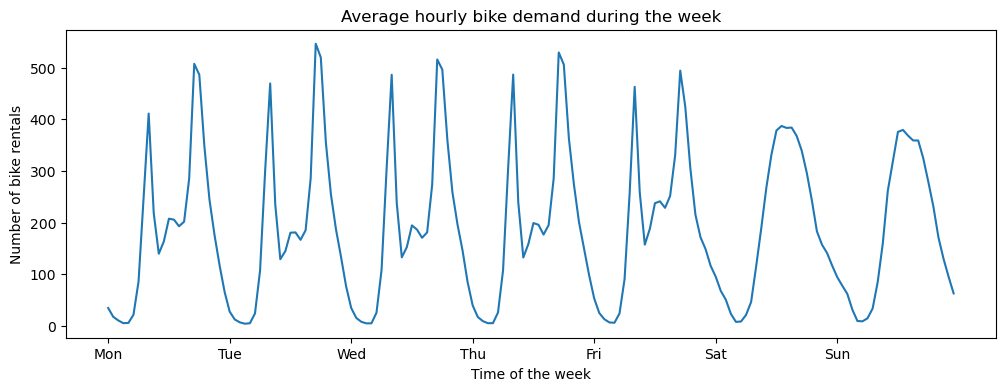

In [80]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = train.groupby(["day_of_week", "hour_of_day"])["cnt"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [85]:
train["cnt"].max()

977

In [86]:
average_week_demand

day_of_week  hour_of_day
0            0               34.560000
             1               17.555556
             2               10.478723
             3                5.184783
             4                5.765957
                               ...    
6            19             231.100000
             20             171.350000
             21             130.130000
             22              95.260000
             23              62.900000
Name: cnt, Length: 168, dtype: float64

### Train, test, split

In [20]:
from sklearn.model_selection import train_test_split
X = train.drop(['date_hour','cnt'],axis=1)
y = train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

### LinearReg

In [21]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

train_test_model(lin_reg)
lin_reg_pred = lin_reg.predict(X_test)


R2: 0.3962673721197123 
MAE: 105.83035602424108 
MSE: 19891.063847531677 
RMSE: 141.03568288745822


### Randomforest

### Pushen Kaggle

In [22]:
def push_dataframe(p_id_values, predictions_values, push=True, csv_file_path=None):
    """
    Creëert een DataFrame met kolommen 'p_id' en 'predictions' en slaat het op naar een CSV-bestand (optioneel).

    Args:
        p_id_values (list): Een lijst met waarden voor de 'p_id'-kolom.
        predictions_values (list): Een lijst met waarden voor de 'predictions'-kolom.
        push (bool): Een boolean die aangeeft of het DataFrame moet worden opgeslagen naar een CSV-bestand.
        csv_file_path (str): Het pad naar het CSV-bestand waarin het DataFrame moet worden opgeslagen (alleen nodig als push=True).

    Returns:
        pd.DataFrame: Een DataFrame met de opgegeven kolommen.
    """
    
    # Flatten the predictions_values array if it's 2D
    if len(predictions_values.shape) > 1:
        predictions_values = predictions_values.flatten()
        
    data = {'date_hour': p_id_values, 'cnt': predictions_values}
    df = pd.DataFrame(data)
    
    if push and csv_file_path:
        df.to_csv(csv_file_path, index=False)
        print(f"CSV file '{csv_file_path}' has been created.")
    
    return df

csv_file_path = r'C:\Users\nimaa\2023-2024\machine_learning\portfolio\Portfolio Deurwaardes\kaggle_sub\lin_reg_pred.csv'

#parameters
id_values = test['date_hour'] # niet veranderen
predictions_values = lin_reg_pred #predictions van model

# push functie toepassen
push_dataframe(id_values, predictions_values, push=True, csv_file_path=csv_file_path)